# Ground-based search

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## The dataset

In [2]:
import numpy as np
from nuance.utils import simulated_ground_based

observations, true = simulated_ground_based(N=5)

/Users/lgrcia/code/dev/nuance/nuance/combined.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


(0.98, 1.02)

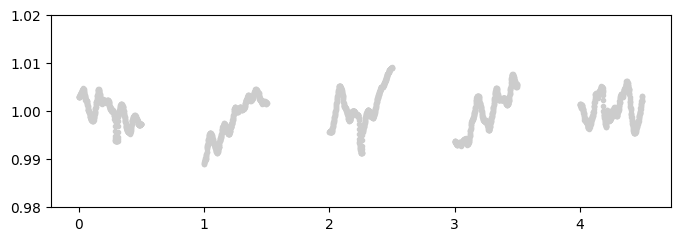

In [3]:
import matplotlib.pyplot as plt

time = np.concatenate([data["time"] for data in observations])
flux = np.concatenate([data["flux"] for data in observations])

plt.figure(figsize=(8, 2.5))
plt.plot(time, flux, ".", c="0.8")
plt.ylim(0.98, 1.02)

In [4]:
mean_error = np.mean([data["error"] for data in observations])

# Fitting the GP

In [30]:
import tinygp
import jaxopt

mean_error = np.mean([data["error"] for data in observations])


def build_gp(params, time=time):
    kernel = tinygp.kernels.quasisep.SHO(**params)
    return tinygp.GaussianProcess(kernel, time, diag=mean_error**2, mean=0.0)


@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(flux - 1.0)


solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run({"omega": 5.0, "quality": 5.0, "sigma": 0.02})
gp = build_gp(soln.params)


@jax.jit
def mean():
    return gp.condition(flux - 1.0, time).gp.mean

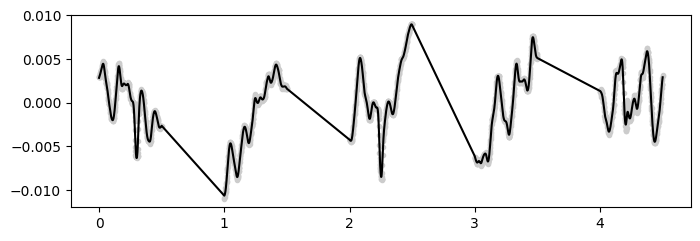

In [31]:
plt.figure(figsize=(8, 2.5))
plt.plot(time, flux - 1, ".", c="0.8")
plt.plot(time, mean(), c="k")

## Setting up the linear search(es)

In [32]:
from nuance import Nuance

Xs = [
    np.vstack([np.ones_like(data["time"]), data["airmass"], data["bkg"], data["fwhm"]])
    for data in observations
]

gps = [build_gp(soln.params, data["time"]) for data in observations]

nus = [
    Nuance(data["time"], data["flux"], gp=gps[i], X=Xs[i])
    for i, data in enumerate(observations)
]

for nu in nus:
    t0s = nu.time.copy()
    Ds = np.linspace(0.01, 0.1, 5)
    nu.linear_search(t0s, Ds)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
from nuance import CombinedNuance

nu = CombinedNuance(nus)

In [34]:
periods = np.linspace(0.2, 1.0, 1000)
search = nu.periodic_search(periods)

  0%|          | 0/1000 [00:00<?, ?it/s]

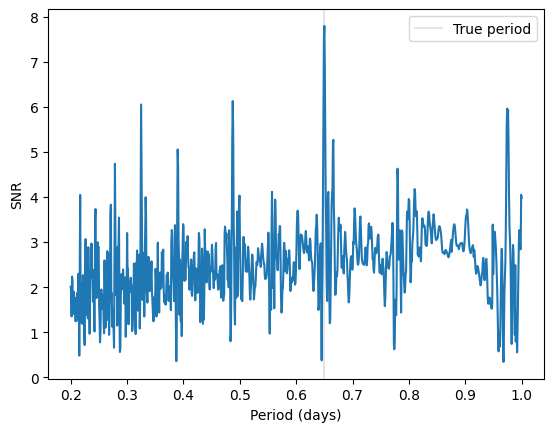

In [35]:
plt.axvline(true["transit_params"]["P"], c="k", alpha=0.1, label="True period")
plt.plot(periods, search.Q_snr)
plt.xlabel("Period (days)")
plt.ylabel("SNR")
plt.legend()

In [36]:
t0, D, P = search.best

found = {
    "t0": t0,
    "D": D,
    "P": P,
}

print(f"\ttrue\tfound")
for param in ["t0", "D", "P"]:
    print(f"{param}\t{found[param]:.3f}\t{(true['transit_params'])[param]:.3f} days")

	true	found
t0	0.299	0.300 days
D	0.033	0.026 days
P	0.650	0.650 days


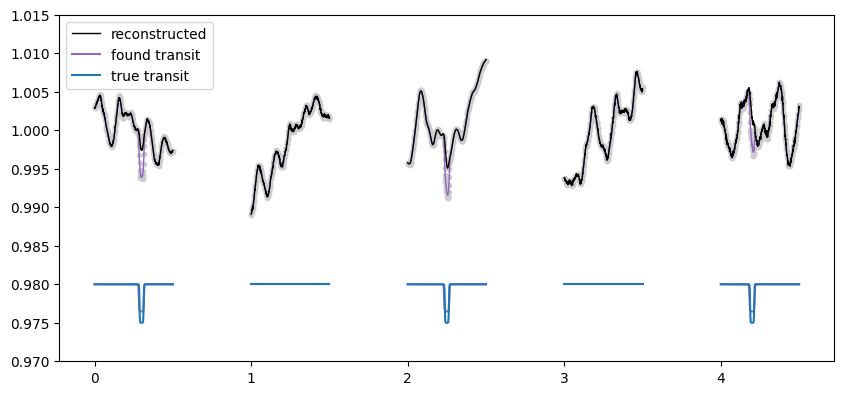

In [41]:
found_signals = np.array(nu.models(*search.best, split=True))

plt.figure(figsize=(10, 4.5))
plt.plot(time, flux, ".", c="0.8")
for i in range(len(observations)):
    systematics, transit, variability = found_signals[:, i, :]
    plt.plot(nu[i].time, systematics + variability + transit, c="C4", lw=1)
    plt.plot(
        nu[i].time,
        systematics + variability,
        c="k",
        lw=1,
        label="reconstructed" if i == 0 else None,
    )

for i in range(len(observations)):
    plt.plot(
        nu[i].time,
        found_signals[1, i, :] + 1 - 0.02,
        c="C4",
        label="found transit" if i == 0 else None,
    )
    plt.plot(
        nu[i].time,
        true["transits"][i] + 1 - 0.02,
        c="C0",
        label="true transit" if i == 0 else None,
    )
plt.ylim(0.97, 1.015)
plt.legend()